In [11]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import fasttext
from fasttext import train_supervised

In [109]:
# open the list of cleaned playlists
with open('cleanedFunction1playlists.pickle', 'rb') as handle:
    playlist_cleaned_dict = pickle.load(handle)

In [ ]:
# for the text classification, we need to create a file with the following format:
# __label__track1 __label__track2 __label__track3 playlist1
with open('cleanedFunction1classification.txt', 'w') as f:
    for key in playlist_cleaned_dict.keys():
            f.write(key + ' ')
            for track in playlist_cleaned_dict[key]:
                f.write('__label__' + track + ' ')
            f.write('\n')

In [5]:
# randomly split the data into 80% training and 20% testing
with open('cleanedFunction1classification.txt', 'r') as f:
    data = f.readlines()
    random.shuffle(data)
    train = data[:int(len(data)*0.8)]
    test = data[int(len(data)*0.8):]
    # write separate playlist.train and playlist.test files
    with open('playlist.train', 'w') as f:
        for line in train:
            f.write(line)
    with open('playlist.test', 'w') as f:
        for line in test:
            f.write(line) 

In [ ]:
# train fasttext model on the playlist names (model tuned with hyperparameters)
# predict tracks given a playlist name
model = fasttext.train_supervised(input='playlist.train', lr=0.5, epoch=500, wordNgrams=4, bucket=200000, dim=50, loss='hs')

# save the model 
model.save_model("models/cleanedFunction1model.bin")

In [110]:
# load the model
textClassificationModel = fasttext.load_model("models/cleanedFunction1model.bin")

# evaluate the model on the test data
N, p, r = textClassificationModel.test('playlist.test')
print("Number of Examples:", N)
print("Precision:", p)
print("Recall:", r)

Number of Examples: 1101
Precision: 0.9836512261580381
Recall: 0.0003952869242881368


In [12]:
# train a doc2vec model on the playlist names
# predict the closest playlists given a description
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

data = list(playlist_cleaned_dict.keys())

# create a list of tagged documents, where each document is a playlist name
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

max_epochs = 100
vec_size = 20
alpha = 0.025

# tuned hyperparameters
model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('Iteration {0}'.format(epoch))
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("models/d2v.model")
print("Model Saved")

In [13]:
# load the model
docEmbeddingModel= Doc2Vec.load("models/d2v.model")

In [27]:
# plot the word embeddings in 2D space
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = docEmbeddingModel.wv[docEmbeddingModel.wv.key_to_index]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# include the playlist name for each point
for i, txt in enumerate(docEmbeddingModel.wv.index_to_key):
    plt.annotate(txt, (X_tsne[i, 0], X_tsne[i, 1]))

# make the plot large so that it is more readable
fig = plt.gcf()
fig.set_size_inches(100, 100)

plt.show()
plt.savefig('results/d2v.png')

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


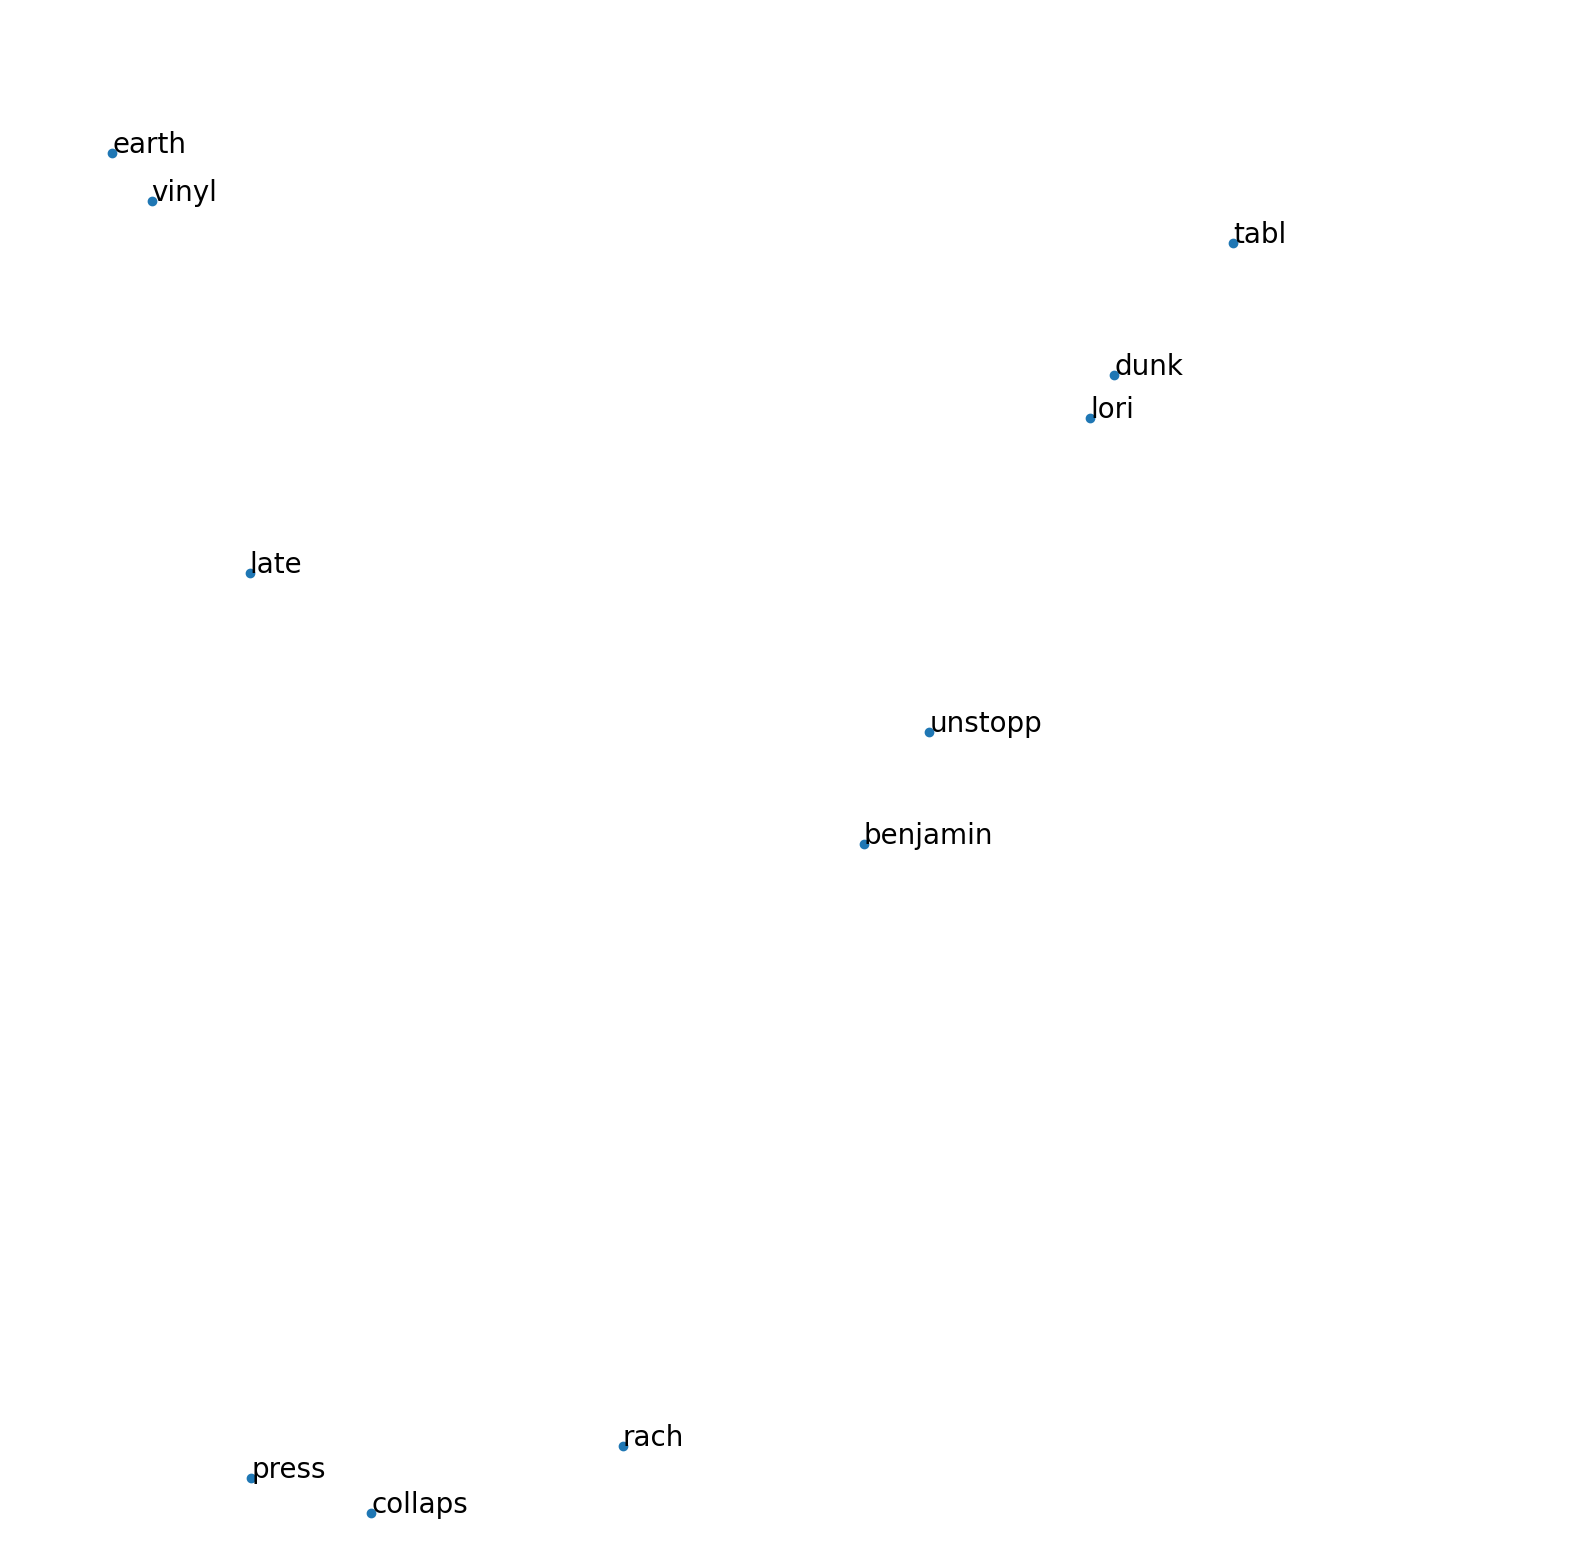

<Figure size 640x480 with 0 Axes>

In [28]:
# plot the word embeddings in 2D space
X = docEmbeddingModel.wv[docEmbeddingModel.wv.key_to_index]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# include the playlist name for each point
for i, txt in enumerate(docEmbeddingModel.wv.index_to_key):
    plt.annotate(txt, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=20)

# make the plot larger to increase readability
fig = plt.gcf()
fig.set_size_inches(20, 20)

# Zoom in on the plot
plt.xlim(-5, 0)
plt.ylim(-5, 0)

# remove the axes and box around the plot
plt.axis('off')
plt.box(False)

# Increase the font size for the plot labels
plt.rcParams.update({'font.size': 20})

plt.show()

# save plot as a png
plt.savefig('results/d2v_zoomed.png')

In [6]:
# list of 10 song descriptions to test the models on
descriptions_list = ["hype workout rap", "relax and chill", "happy roadtrip", "throwback", "sad", "upbeat summer", "alternative rock", "bedtime", "christmas", "country", "studying"]

In [7]:
# opened the list of cleaned playlists
with open('cleanedFunction1playlists.pickle', 'rb') as handle:
    playlist_cleaned_dict = pickle.load(handle)

# get a list of all playlist names
playlist_names = list(playlist_cleaned_dict.keys())

In [13]:
# open the song set dictionary
with open('song_set.pickle', 'rb') as handle:
    songSet = pickle.load(handle)

In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import words

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
english_words = set(words.words())

def clean_text(text):
    # make all text lowercase
    text = text.lower()
    # replace 2k with 20
    text = text.replace('2k', '20')
    # remove extra spaces between words
    text = re.sub('\s+', ' ', text)
    # replace synonyms/short forms that occur frequently in playlist names)
    text = text.replace('hoco', 'homecoming')
    # replace tb or tbt with throwback
    text = text.replace('tb', 'throwback')
    text = text.replace('tbt', 'throwback')
    # for each word in the text that is in the english dictionary, replace it with the stem of the word
    text = " ".join([stemmer.stem(word) for word in text.split() if word in english_words])
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove words without vowels
    text = re.sub(r'\b[^aeiouyAEIOUY\s]+\b', '', text)
    # remove stop words
    text_tokens = text.split()
    cleaned_tokens = filter(lambda w: not w in stop_words, text_tokens)
    text = " ".join(cleaned_tokens)
    # replace common decade texts
    text = re.sub(r"1990[']?s|90[']?s", "90s", text)
    text = re.sub(r"2000[']?s|00[']?s", "00s", text)
    text = re.sub(r"2010[']?s|10[']?s", "10s", text)
    text = re.sub(r"1980[']?s|80[']?s", "80s", text)
    text = re.sub(r"1970[']?s|70[']?s", "70s", text)
    text = re.sub(r"1960[']?s|60[']?s", "60s", text)
    # remove the words music, mix, vibes, playlist, throwbacks, spotify
    text = text.replace('music', '')
    text = text.replace('mix', '')
    text = text.replace('vibes', '')
    text = text.replace('playlist', '')
    text = text.replace('throwbacks', '')
    text = text.replace('spotify', '')
    # don't include playlists without a name or category 
    unkowns = [" 's playlist", "untitled", "random", "jams", "songs i like", "spotify.me", "idk", "i dunno", "i dont know", "jamz", "discover"]
    for i in unkowns:
        if i in text:
            text = ""
            break
    return text

In [115]:
# model prediction using docEmbedding

# given a description, get the 5 closest playlists and select 1 song from each playlist
def getTracksFromDescription(descriptions):
    # get the 5 closest playlists
    similarPlaylists = docEmbeddingModel.dv.most_similar(positive=[docEmbeddingModel.infer_vector(descriptions)], topn=5)
    tracks = []
    for playlist in similarPlaylists:
        name = playlist_names[int(playlist[0])]
        # choose a random song from that playlist
        def generateRand(length):
            index = random.randint(0, length)
            track = list(playlist_cleaned_dict[name])[index]
            return track
        # make sure recommendations are unique
        track = generateRand(len(playlist))
        while track in tracks:
            track = generateRand(len(playlist))
            continue
        tracks.append(track)
    return tracks

# given a track, return the track name and artist 
def getArtistfromTrack(track):
    # find the track in songSet
    for song in songSet:
        if song[0] == track:
            return track + " by " + song[2]
        
doc2VecRecs = []

# for each input description, print the top 10 recommended tracks
for description in descriptions_list:
    print("Input Description:", description)
    print("\n5 Recommended Tracks: \n")
    tracks = getTracksFromDescription([clean_text(description)])
    doc2VecRecs.append(tracks)
    for track in tracks:
        print(getArtistfromTrack(track))
    print("\n")

Input Description: hype workout rap

5 Recommended Tracks: 

Time Of The Season (Mono Version) by The Zombies
Freazy by Wolf Alice
Mr. Goodtime (feat. Ronnie Dunn) by Colt Ford
Burnin' for You by Blue Öyster Cult
Dance With Me by Lost Frequencies


Input Description: relax and chill

5 Recommended Tracks: 

Lay Your Love Down - Single Version by Wolf Gang
Not Walkin' Away by Emily Hearn
Drama! by Erasure
Cash Money by J-Soul
No Money by Rico


Input Description: happy roadtrip

5 Recommended Tracks: 

Learning To Love by Consumed By Fire
Tree to Grow by The Lone Bellow
You Found Me by Willy Tea Taylor
No Money by Rico
Forever by Fuel


Input Description: throwback

5 Recommended Tracks: 

The One You Want by The Tide
Dance With Me by Lost Frequencies
You Found Me by Willy Tea Taylor
No Church In The Wild by NEXT Collective
Ditty - Radio Edit by Paperboy


Input Description: sad

5 Recommended Tracks: 

Uncover by White Flag
Phascination Phase (From "Сумерки") by The City of Prague Phil

In [116]:
# text classification model prediction

fastTextRecs = []
# predict the track uri's for the given words
for description in descriptions_list:
    print("Input Description:", description)
    print("\n5 Recommended Tracks: \n") 
    track_predictions = textClassificationModel.predict(clean_text(description), k=10)
     # select the first 5 unique predicted track uri's
    track_predictions = np.unique(track_predictions[:5], return_counts=True)
    # get the track names for the predicted track uri's
    count = 0
    mini_list = []
    for track in track_predictions[0]:
        if count == 5:
            break
        if getArtistfromTrack(track[9:]) is None:
            continue
        count += 1
        print(getArtistfromTrack(track[9:]))
        mini_list.append(track[9:])
    print("\n")
    fastTextRecs.append(mini_list)

Input Description: hype workout rap

5 Recommended Tracks: 

1901 by The MIT Logarhythms
Bohemian by 1991
Breezeblocks by Piano Tribute Players
Comme by Saule
Eres by David Amparo DK


Input Description: relax and chill

5 Recommended Tracks: 

Bohemian by 1991
Breezeblocks by Piano Tribute Players
Comme by Saule
En by Jizue
Eres by David Amparo DK


Input Description: happy roadtrip

5 Recommended Tracks: 

Breezeblocks by Piano Tribute Players
Comme by Saule
En by Jizue
Eres by David Amparo DK
Planetarium by Bradford Cox


Input Description: throwback

5 Recommended Tracks: 

Breezeblocks by Piano Tribute Players
Comme by Saule
En by Jizue
Planetarium by Bradford Cox
Shaky by The Duke & The King


Input Description: sad

5 Recommended Tracks: 

Breezeblocks by Piano Tribute Players
Comme by Saule
En by Jizue
Eres by David Amparo DK
Planetarium by Bradford Cox


Input Description: upbeat summer

5 Recommended Tracks: 

1901 by The MIT Logarhythms
Bohemian by 1991
Breezeblocks by Piano

In [30]:
# get dataframe from dictionary
df = pd.DataFrame.from_dict(playlist_cleaned_dict, orient='index')

In [31]:
# ** our accuracy metric calculation **
# for each track, add 1 to the accuracy score if the track is in a playlist containing one of the input words
# divide the accuracy score by 5 to get the accuracy for that input description 
# repeat for all input descriptions and average the accuracy scores to get the overall accuracy
def calcAccuracy(recs):
    length = len(recs)
    avg_accuracy = 0
    for playlist, tracks in enumerate(recs):
        playlist_name = word_tokenize(clean_text(descriptions_list[playlist]))
        tracks = recs[playlist]
        # check if any of the input description words are in the playlists
        new_df = df[df.index.isin([name for name in df.index if any(word in name for word in playlist_name)])]
        # check if any of the tracks are in the playlists, if it is, add 1 to accuracy
        count = 0
        for track in tracks:
            for name in new_df.index:
                if track in new_df.loc[name].tolist():
                    count += 1
        accuracy = count / 5
        avg_accuracy += accuracy
    accuracy = avg_accuracy / length
    return accuracy 

doc2VecAccuracy = calcAccuracy(doc2VecRecs)
fasttextAccuracy = calcAccuracy(fastTextRecs)   

print("Doc2Vec Accuracy:", doc2VecAccuracy)
print("FastText Accuracy:", fasttextAccuracy)

KNN Accuracy: 0.0


In [133]:
# compare the accuracy of the two models with randomly generated songs
randomRecs = []
for description in descriptions_list:
    print("Input Description:", description)
    print("\n5 Recommended Tracks: \n")
    tracks = []
    for i in range(5):
        index = random.randint(0, len(songSet))
        track = list(songSet)[index][0]
        tracks.append(track)
        print(getArtistfromTrack(track))
    print("\n")
    randomRecs.append(tracks)

randomAccuracy = calcAccuracy(randomRecs)
print("Random Accuracy:", randomAccuracy)

Input Description: hype workout rap

5 Recommended Tracks: 

When I'm Sixty Four by Kenny Ball
Beat It Up (feat. The Vybe) by Lil Howie
That's All Right - Live by Elvis Presley
Relaxation & Solutions - Instrumental by Sunyata Project
Single by Frith


Input Description: relax and chill

5 Recommended Tracks: 

Soul 4 My Soul - Bonus Track by Anthony Green
Idee by Daso
Corrido De Manuel González by La Arrolladora Banda El Limón De Rene Camacho
63 (She Was Trying to Sleep, I Was Trying to Breathe) by Plastik Joy
Goodbye Tonight by Metaform


Input Description: happy roadtrip

5 Recommended Tracks: 

Crown Him With Many Crowns by Saint Michael's Singers
Where It Ends, Where It Begins by Sacco
Stop Making Sense - Original Mix by Brett Johnson
Deltaplane by Ingrid St-Pierre
Aaaaadddimean by J-Diggs


Input Description: throwback

5 Recommended Tracks: 

Floodgate by Estuarie
Waves by Kopecky
Don't Wait For Me by Morris Day
The Flame by Protoje
Funk Me by H.W.A.


Input Description: sad

5 R

In [3]:
# open the generated audio features dataset
with open ('audio_features.pickle', 'rb') as handle:
    audio_features = pickle.load(handle)

audio_features_df = pd.DataFrame.from_dict(audio_features, orient='index')

In [25]:
# open model.pickle file
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

with open('random_song_df.pickle', 'rb') as handle:
    random_song_df = pickle.load(handle)

def get_similar_playlists(playlist_name):
    # get the 5 most similar playlists
    similar_playlists = docEmbeddingModel.dv.most_similar(positive=[docEmbeddingModel.infer_vector([clean_text(playlist_name)])], topn=20)
    # get the playlist names
    similar_playlists = [playlist_names[int(playlist[0])] for playlist in similar_playlists]
    return similar_playlists

for description in descriptions_list:
    # Use the model to predict audio feature values for new songs
    new_df = pd.DataFrame(columns=random_song_df.columns[9:])
    # set the values of the new dataframe to 0
    new_df.loc[0] = 0
    # set the values of the new dataframe for the tags to 1
    for playlist in get_similar_playlists(description):
        new_df.loc[0, playlist] = 1
    # generate predicted audio features
    new_features = model.predict(new_df)[0]
    # save the predicted audio features to a text file with a new line for each description
    with open('predicted_audio_features.txt', 'a') as f:
        f.write(str(new_features) + '\n')
    print('Predicted audio features:', new_features)



Predicted audio features: [ 3.53785451e-01  5.50726203e-01  5.85481095e-01  2.29020482e-01
  2.13156491e-01 -9.73911357e+00  9.23281319e-02  1.19492581e+02
  4.74516735e-01]
Predicted audio features: [ 3.55176081e-01  5.49932216e-01  5.79773740e-01  2.23652368e-01
  2.06715491e-01 -9.75640639e+00  8.95828770e-02  1.18622220e+02
  4.68401425e-01]
Predicted audio features: [ 3.50835496e-01  5.50801745e-01  5.88634309e-01  2.26684973e-01
  2.12593113e-01 -9.67594523e+00  9.13758304e-02  1.19538774e+02
  4.77251152e-01]
Predicted audio features: [ 3.41050884e-01  5.45825122e-01  5.98395542e-01  2.19598371e-01
  2.13309398e-01 -9.51784329e+00  9.12019378e-02  1.20250938e+02
  4.79115917e-01]
Predicted audio features: [ 3.42825712e-01  5.53016490e-01  5.96573954e-01  2.18291537e-01
  2.14194179e-01 -9.48341353e+00  9.63286882e-02  1.19374152e+02
  4.70869418e-01]
Predicted audio features: [ 3.52994556e-01  5.49064786e-01  5.86178378e-01  2.26806140e-01
  2.09901637e-01 -9.70499890e+00  9.107